> ไฟล์ Python Notebook สำหรับหนังสือ "การเรียนรู้ของเครื่องสำหรับเคมีควอนตัม" โดย รังสิมันต์ เกษแก้ว

> This is a Python notebook for "Machine Learning for Quantum Chemistry" book by Rangsiman Ketkaew

# Introduction to Machine Learning for Chemists in Python
### A Primer about Machine Learning in Catalysis – A Tutorial with Code


In this Jupyter Notebook, we will repeat the exercises introduced in the notebook 1, but with chemical data. This tutorial is based on the publication  A Primer about Machine Learning in Catalysis – A Tutorial with Code

https://chemistry-europe.onlinelibrary.wiley.com/doi/epdf/10.1002/cctc.202000234

The following tutorial is focused on the oxidative coupling of methane (OCM) described as

2 CH$_4$ + O$_2$ -> C$_2$H$_4$ + 2 H$_2$O.

A good OCM catalyst contains at least two elemenst from the following list: Sr, Ba, Mg, Ca, La, Nd, Sm, Ga, Bi, Mo, W, Mn, Re, Li, Na, Cs, F, Cl. At the same time, one of them needs to be able to form a carbonate while the second element is in a thermally stable form. This leads to a catalyst composed of stable oxide and active species.

Following tutorial will draw some conclusions from the published data on the catalysts using various ML workflows introduced in previous sections.

First, let us import all the modules we need to start our tutorial on *Machine Learning* :

In [1]:
import numpy as np  # The numpy package
import pandas as pd # The pandas data framework
import matplotlib.pyplot as plt # The plotting library
import sklearn as sklearn # General purpose ML framework for python
import tensorflow as tf # TensorFlow framework

2022-11-16 09:55:54.429439: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 09:55:54.584508: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-16 09:55:54.584534: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-16 09:55:54.617886: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-16 09:55:55.684711: W tensorflow/stream_executor/pla

In [2]:
# %matplotlib inline

In [3]:
np.random.seed(42)

In [4]:
#Data are available as an Excel file 
url = 'https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-019-08325-8/MediaObjects/41467_2019_8325_MOESM3_ESM.xls'

In [5]:
# This creates a pandas DataFrame using data in url, a sort of a table with a lot of data science functionalities implemented.
raw_data = pd.read_excel(url, sheet_name=1)

In [6]:
raw_data.head()

,Catalyst Nr,Nr of publication,Cation 1,Cation 1 mol%,Cation 2,Cation 2 mol%,Cation 3,Cation 3 mol%,Cation 4,Cation 4 mol%,...,p(CH4)/p(O2),"p total, bar","Contact time, s","X(O2), %","X(CH4), %","S(COx), %","S(C2=), %","S(C2-), %","S(C2), %","Y(C2), %"
0,1,1,Mn,9.2,NaN,NaN,NaN,NaN,NaN,NaN,...,4.761905,1.013,0.04,NaN,11.0,NaN,NaN,NaN,45.500000,5.0050
1,2,1,Cd,4.7,NaN,NaN,NaN,NaN,NaN,NaN,...,4.761905,1.013,0.04,NaN,10.0,NaN,NaN,NaN,40.000000,4.0000
2,3,1,Sn,4.5,NaN,NaN,NaN,NaN,NaN,NaN,...,4.761905,1.013,0.04,NaN,8.4,NaN,NaN,NaN,4.800000,0.4032
3,4,1,Ti,10.4,NaN,NaN,NaN,NaN,NaN,NaN,...,4.761905,1.013,0.04,NaN,6.8,NaN,NaN,NaN,44.099998,2.9988
4,5,1,Pt,2.8,NaN,NaN,NaN,NaN,NaN,NaN,...,4.761905,1.013,0.04,NaN,8.0,NaN,NaN,NaN,1.300000,0.1040


In [7]:
# This cell basically collects the important data. It can be skipped.
# We collect the relevant data
# Pivot function sort original columns with respect to the elements
cation1 = raw_data.pivot(columns='Cation 1', values='Cation 1 mol%')
cation2 = raw_data.pivot(columns='Cation 2', values='Cation 2 mol%')
cation3 = raw_data.pivot(columns='Cation 3', values='Cation 3 mol%')
cation4 = raw_data.pivot(columns='Cation 4', values='Cation 4 mol%')
anion1 = raw_data.pivot(columns='Anion 1', values='Anion 1 mol%')
anion2 = raw_data.pivot(columns='Anion 2', values='Anion 2 mol%')
support1 = raw_data.pivot(columns='Support 1', values='Support 1 mol%')
support2 = raw_data.pivot(columns='Support 2', values='Support 2 mol%')

#We need to create a pivot_list which holds the single pivoted tables and combine them together with concat

pivot_lists = [cation1, cation2, cation3, cation4, anion1, anion2, support1, support2]
concat_pivot_lists = pd.concat(pivot_lists, axis=1, sort=True)
# Here we collect the percentage of composition of each element
composition = concat_pivot_lists.groupby(level=0, axis=1).sum()/100
# Extraction of the publication numbers pub_nr and reaction conditions
pub_nr = raw_data.iloc[:,0]
reaction_data = raw_data.iloc[:,19:]

cleaned_list = [pub_nr, composition, reaction_data]
data_cleaned = pd.concat(cleaned_list, axis=1, sort=True)

In [8]:
# some values are missing and are replaced with 0
data_cleaned = data_cleaned.fillna(0)

In [9]:
# This is the clean data that we can use for the analysis
data_cleaned.head()

,Catalyst Nr,Ag,Al,Au,B,Ba,Be,Bi,Br,C,...,p(CH4)/p(O2),"p total, bar","Contact time, s","X(O2), %","X(CH4), %","S(COx), %","S(C2=), %","S(C2-), %","S(C2), %","Y(C2), %"
0,1,0.0,0.908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.761905,1.013,0.04,0.0,11.0,0.0,0.0,0.0,45.500000,5.0050
1,2,0.0,0.953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.761905,1.013,0.04,0.0,10.0,0.0,0.0,0.0,40.000000,4.0000
2,3,0.0,0.955,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.761905,1.013,0.04,0.0,8.4,0.0,0.0,0.0,4.800000,0.4032
3,4,0.0,0.896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.761905,1.013,0.04,0.0,6.8,0.0,0.0,0.0,44.099998,2.9988
4,5,0.0,0.972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.761905,1.013,0.04,0.0,8.0,0.0,0.0,0.0,1.300000,0.1040


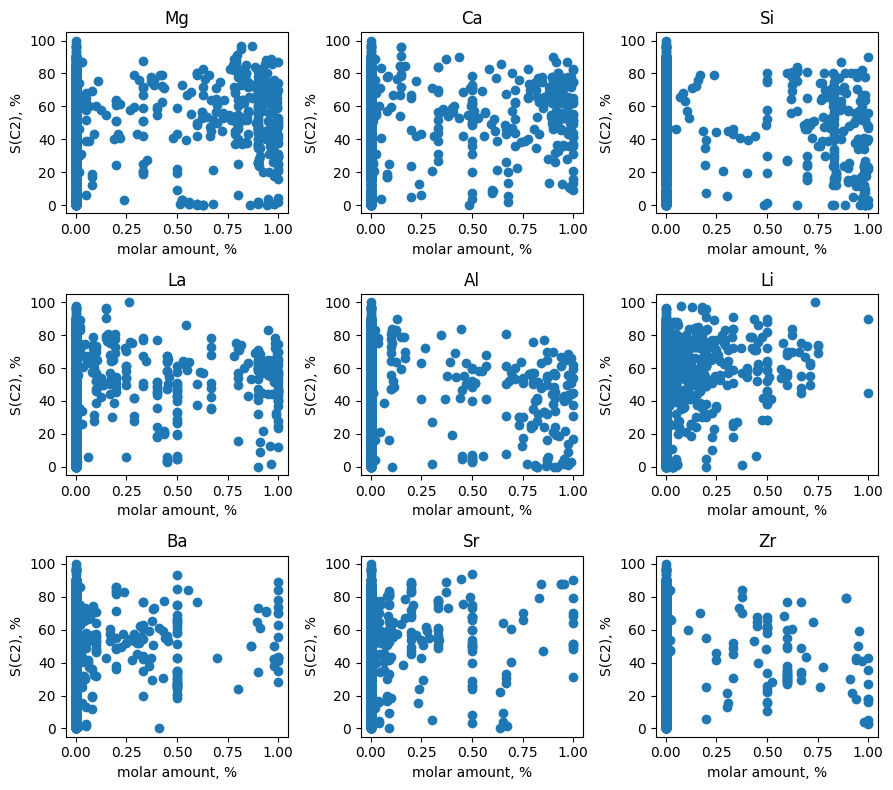

In [10]:
fig, axes = plt.subplots(figsize=[9,8], ncols=3, nrows=3)

most_common_elements = composition.mean(axis=0).sort_values(ascending=False).head(9).keys()

for i, element in enumerate(most_common_elements):
    ax = axes.ravel()[i]
    ax.set_title(element)
    ax.set_xlabel('molar amount, %')
    ax.set_ylabel('S(C2), %')
    ax.scatter(x=data_cleaned[element], y=data_cleaned['S(C2), %'])

plt.tight_layout()
plt.show()

# Unsupervised Learning 
### Libraries loaded from Scikit-Learn (https://scikit-learn.org/stable/index.html) 

In [11]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [12]:
composition.head()

,Ag,Al,Au,B,Ba,Be,Bi,Br,C,Ca,...,Te,Th,Ti,Tm,V,W,Y,Yb,Zn,Zr
0,0.0,0.908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.955,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.104,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## K-Means
The KMeans algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares (see below). This algorithm requires the number of clusters to be specified. (https://scikit-learn.org/stable/modules/clustering.html#k-means)

To find out how many clusters should be ideally used, the "elbow method" can be used.
With each cluster the sum of squared distances decreases, evntually converging to zero if each point is a cluster. The optimal amount of clusters per point is given by the "elbow" of the plotted curve.

In [13]:
#K-Means Clustering
# "Elbow curve" helps to define suitable number of clusters 
k_ellbow = []
for E in range(1,15):
    kmeans = KMeans(n_clusters=E)
    kmeans.fit(composition)
    score = kmeans.score(composition)
    k_ellbow.append(score)

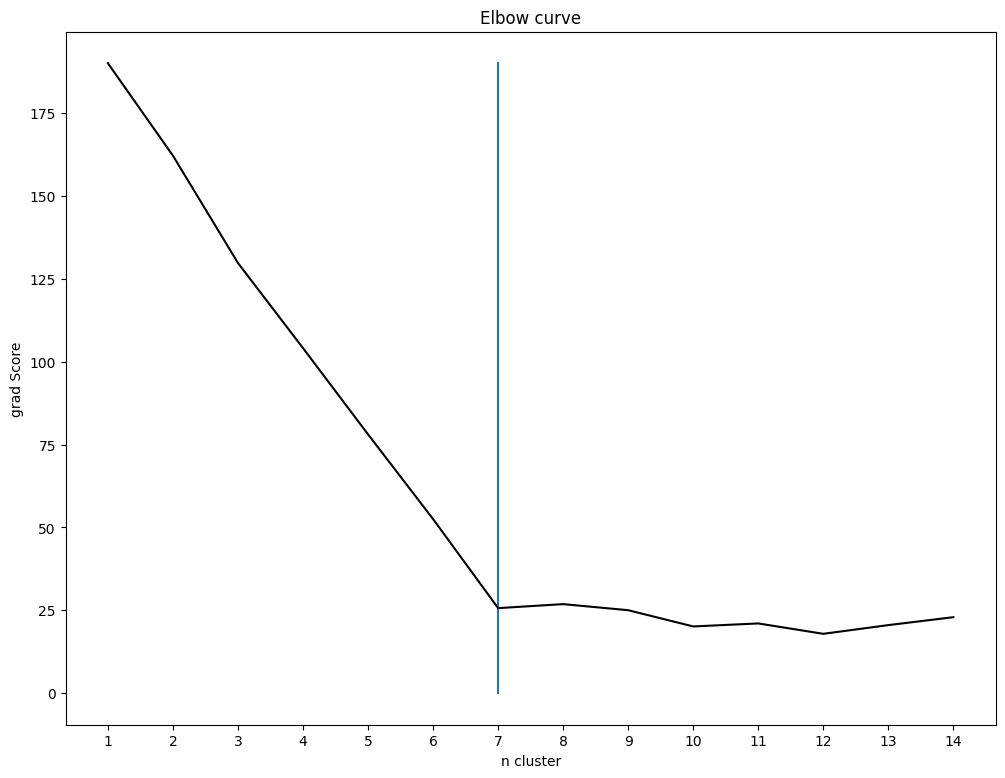

In [14]:
plt.figure(figsize=(12,9))
plt.title('Elbow curve')
plt.xlabel('n cluster')
plt.ylabel('grad Score')
plt.plot([7,7],[0,np.max(np.gradient(k_ellbow))])
plt.xticks(np.arange(1, len(k_ellbow) + 1))
plt.plot(range(1, len(k_ellbow) + 1), np.gradient(k_ellbow), 'k');

In [15]:
#Lets use K-Means Cluster prediction for 7 clusters
cluster = KMeans(n_clusters=7)
cluster.fit(composition)
cluster_predictions = cluster.predict(composition)

## Principal Component Analysis (PCA)
PCA is used to decompose a multivariate dataset in a set of successive orthogonal components that explain a maximum amount of the variance. In scikit-learn, PCA is implemented as a *transformer* object that learns components in its fit method, and can be used on new data to project it on these components. (https://scikit-learn.org/stable/modules/decomposition.html)

In [16]:
#Dimensionality Reduction of the Data with Principal Component Analysis 
pca = PCA(n_components=2)
reducer_01 = pca.fit_transform(composition)

## t-distributed Stochastic Neighbor Embedding (t-SNE)

t-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results. (https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

It can be used as an alternative/complementary approach to PCA.

In [17]:
tsne = TSNE(n_components=2, random_state=42, init='random', n_jobs=-1)
reducer_02 = tsne.fit_transform(composition)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


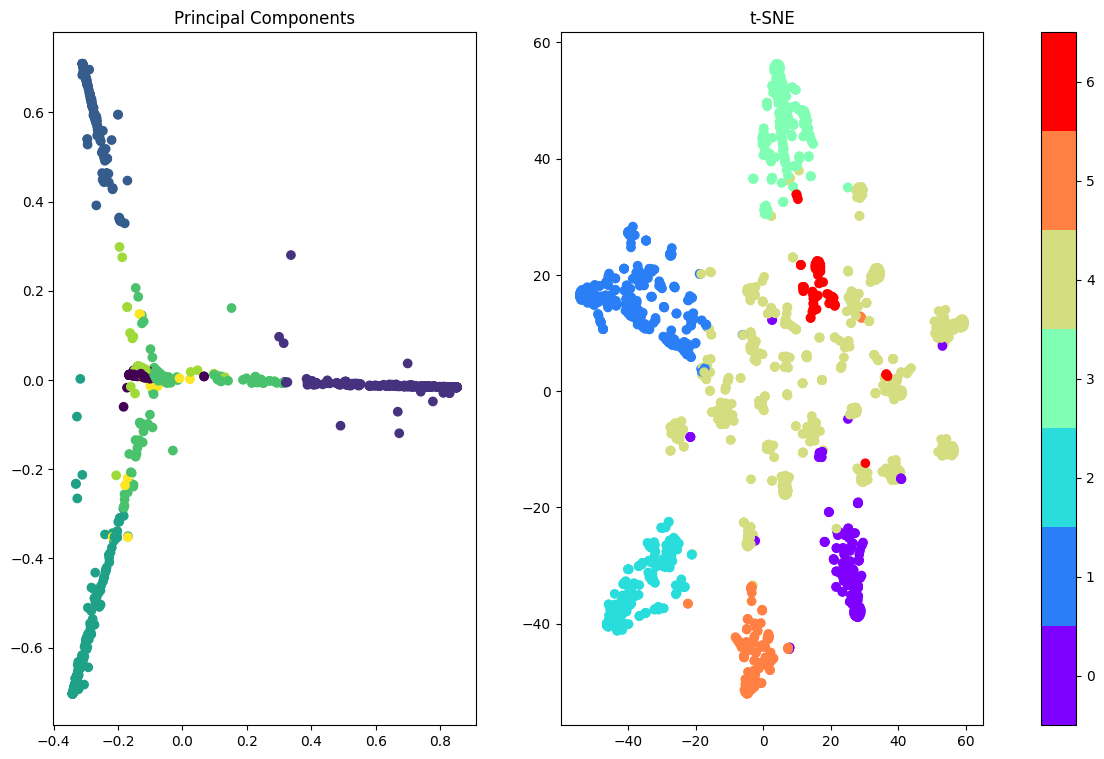

In [18]:
fig, axs = plt.subplots(1,2,figsize=(15,9))
axs[0].set_title('Principal Components')
axs[1].set_title('t-SNE')
plot1 = axs[0].scatter(reducer_01[:,0], reducer_01[:,1], c=cluster_predictions, cmap=plt.cm.get_cmap('viridis',8))
plot2 = axs[1].scatter(reducer_02[:,0], reducer_02[:,1], c=cluster_predictions, 
                       cmap=plt.cm.get_cmap('rainbow',7), vmin=-0.5, vmax=6.5)
fig.colorbar(plot2, ax=axs);


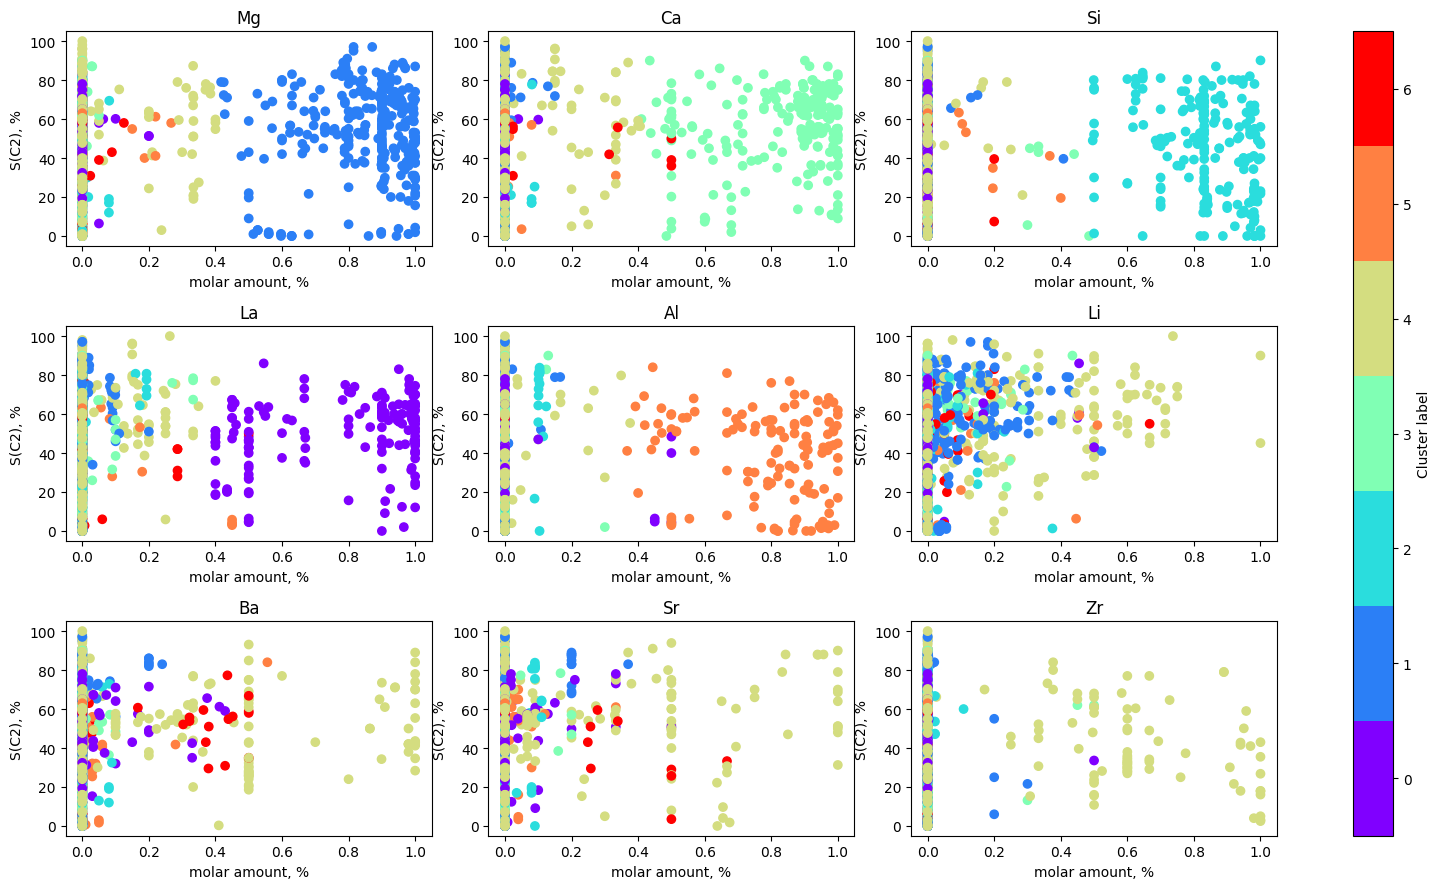

In [19]:
#Coloring of the original composition by the cluster number

elements = composition.mean(axis=0).sort_values(ascending=False).head(9).keys()

fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(16,9))
# fig.subplots_adjust(wspace=0.3, hspace=0.3)
for count, ax in enumerate(axs.flat):
    ax.set_title(elements[count])
    ax.set_xlabel('molar amount, %')
    ax.set_ylabel('S(C2), %')
    ax.scatter(data_cleaned[elements[count]],data_cleaned['S(C2), %'],c=cluster_predictions, 
               cmap=plt.cm.get_cmap('rainbow', 7), vmin=-0.5, vmax=6.5)

# cb = fig.colorbar(plot, ax=axs)
plt.tight_layout()
im = axs[0,2].collections[0]
cbar = fig.colorbar(im, ax=axs, ticks=range(7), label='Cluster label')

plt.show()

# Supervised Learning



In [20]:
from sklearn.model_selection import train_test_split

In [21]:
composition

,Ag,Al,Au,B,Ba,Be,Bi,Br,C,Ca,...,Te,Th,Ti,Tm,V,W,Y,Yb,Zn,Zr
0,0.0,0.908,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.953,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.955,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.896,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,...,0.0,0.0,0.104,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.972,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1797,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1798,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.238,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1799,0.0,0.000,0.0,0.0,0.0,0.0,0.238,0.0,0.0,0.000,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1800,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
X = composition
Y = data_cleaned['S(C2), %'] / 100

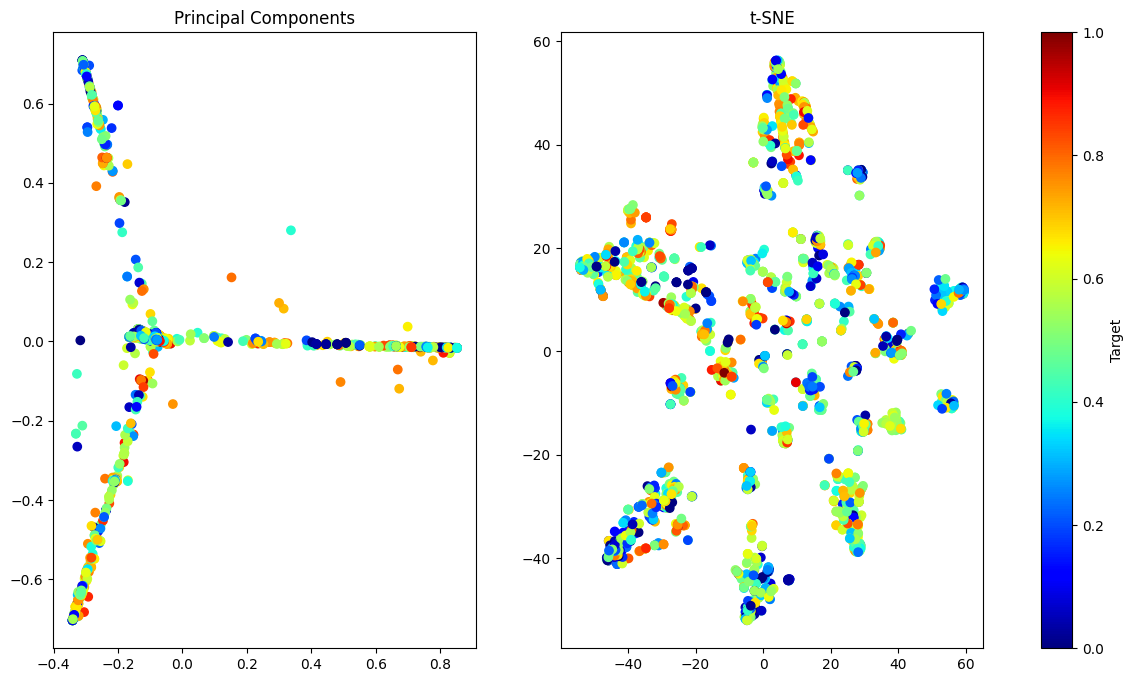

In [23]:
fig, axs = plt.subplots(1,2,figsize=(15,8))
axs[0].set_title('Principal Components')
axs[1].set_title('t-SNE')
plot1 = axs[0].scatter(reducer_01[:,0], reducer_01[:,1], c=Y, cmap='jet')
plot2 = axs[1].scatter(reducer_02[:,0], reducer_02[:,1], c=Y, cmap='jet')

cbar = fig.colorbar(plot2, ax=axs)
cbar.set_label('Target')
plt.show()

### Train-Test Split
The train-test split is performed to separate your dataset into two distinct subsets. The train set is used to forge your model, whereas the test set, which was **never** used during training, is used to validate the built model.

For more information, please refer to https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Support Vector Machine (SVM)
SVM's are a powerful method that can be used for regression, classification and outlier detection tasks.

For more details, please refer to https://scikit-learn.org/stable/modules/svm.html

In [25]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV

In [26]:
hyper_params_svr = {'gamma':np.random.normal(12, 2, 10000),'C':np.random.normal(1, 0.2, 10000)}

In [27]:
c_params = np.linspace(0.001, 10, 30)

train_mean_squared_error = []
test_mean_squared_error = []

for cc in c_params:
    svr = SVR(kernel='rbf', C=cc)
    svr.fit(X_train, Y_train)
    train_mean_squared_error.append(sklearn.metrics.mean_squared_error(svr.predict(X_train), Y_train))
    test_mean_squared_error.append(sklearn.metrics.mean_squared_error(svr.predict(X_test), Y_test))

# print('Best Estimator', g_search.best_estimator_)

In [28]:
best_c = c_params[np.argmin(test_mean_squared_error)]

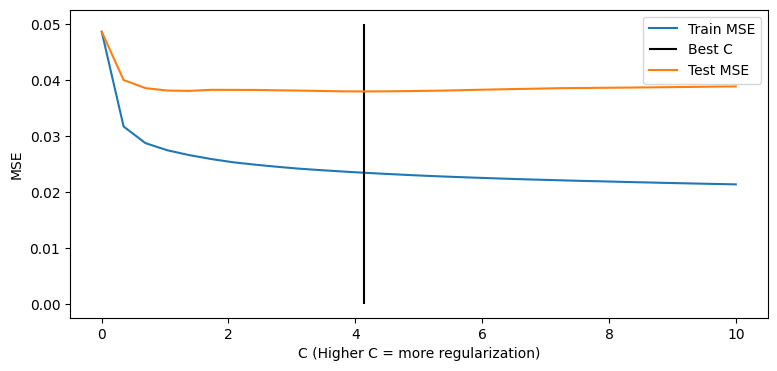

In [29]:
fig, ax = plt.subplots(figsize=[9,4])
ax.plot(c_params, train_mean_squared_error, label='Train MSE')
ax.vlines([best_c], 0, 0.05, label='Best C', edgecolor='black')
ax.plot(c_params, test_mean_squared_error, label='Test MSE')
ax.set_ylabel('MSE')
ax.set_xlabel('C (Higher C = more regularization)')
ax.legend()
plt.show()

In [30]:
print('Best C: ', best_c)

Best C:  4.138517241379311


--------------------

In [31]:
svr = SVR(kernel='rbf', C=best_c)
svr.fit(X_train, Y_train)
svr_train_predictions = svr.predict(X_train)
svr_test_predictions = svr.predict(X_test)

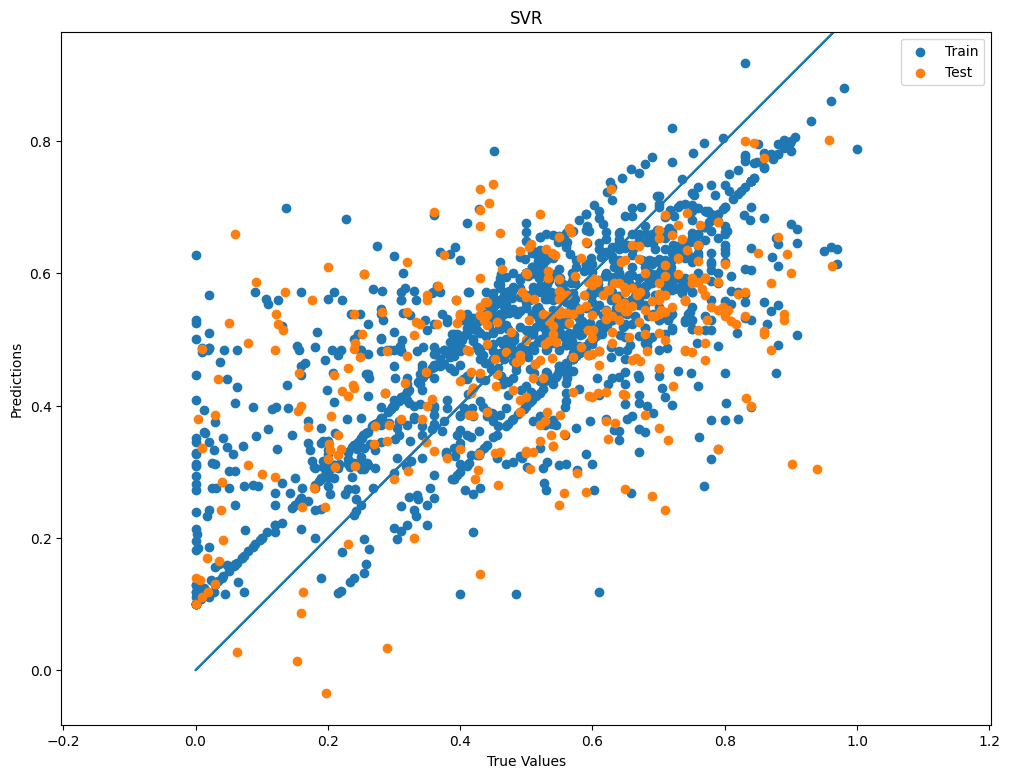

In [32]:
plt.figure(figsize=(12,9))
plt.scatter(Y_train, svr_train_predictions, label='Train')
plt.scatter(Y_test, svr_test_predictions, label='Test')
plt.legend()
plt.title('SVR')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.plot(Y, Y);


## Random Forest

The random forest is an algorithm based on ensemble learning. It consists of multiple decision trees joined to form a more powerful prediction model, hence creating a *forest of trees*. Similar to the SVM, the random forest algorithm can be used for both regression and classification tasks.

In what follows, let's focus on applying a **Random Forest Regression** (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)


In [33]:
from sklearn.ensemble import RandomForestRegressor

In [34]:
ntrees_list = np.arange(1,100, 5)
train_errors = []
test_errors = []
for ntrees in ntrees_list:
    rfr = RandomForestRegressor(n_estimators=ntrees)
    rfr.fit(X_train, Y_train)
    train_preds = rfr.predict(X_train)
    test_preds = rfr.predict(X_test)

    train_error = sklearn.metrics.mean_squared_error(train_preds, Y_train)
    train_errors.append(train_error)
    
    test_error = sklearn.metrics.mean_squared_error(test_preds, Y_test)
    test_errors.append(test_error)

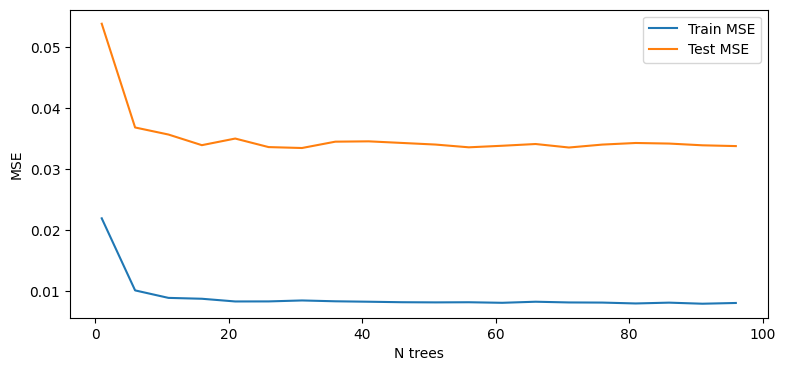

In [35]:
fig, ax = plt.subplots(figsize=[9,4])
ax.plot(ntrees_list, train_errors, label='Train MSE')
# ax.vlines([best_c], 0, 11.8, label='Best C', edgecolor='black')
ax.plot(ntrees_list, test_errors, label='Test MSE')
ax.set_ylabel('MSE')
ax.set_xlabel('N trees')
ax.legend()
plt.show()

In [36]:
rfr = RandomForestRegressor(n_estimators=100)
rfr.fit(X_train, Y_train)

RandomForestRegressor()

In [37]:
feature_importances = rfr.feature_importances_

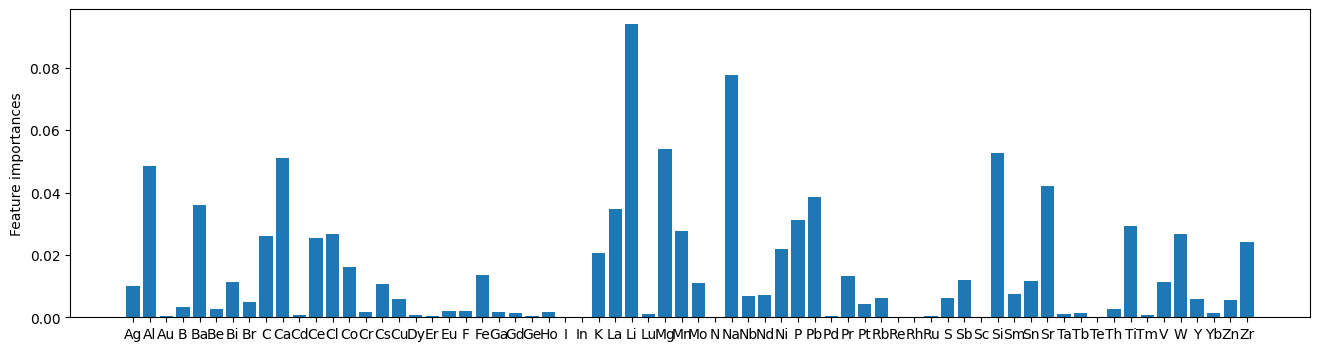

In [38]:
fig, ax = plt.subplots(figsize=[16,4])

ax.bar(composition.columns, feature_importances)
ax.set_ylabel('Feature importances')
plt.show()

In [39]:
Y_pred_train = rfr.predict(X_train)

In [40]:
Y_pred_test = rfr.predict(X_test)

In [41]:
print('Score on training set:', rfr.score(X_train, Y_train))

Score on training set: 0.840807831224063


In [42]:
print('Score on test set:', rfr.score(X_test, Y_test))

Score on test set: 0.32615130400578607


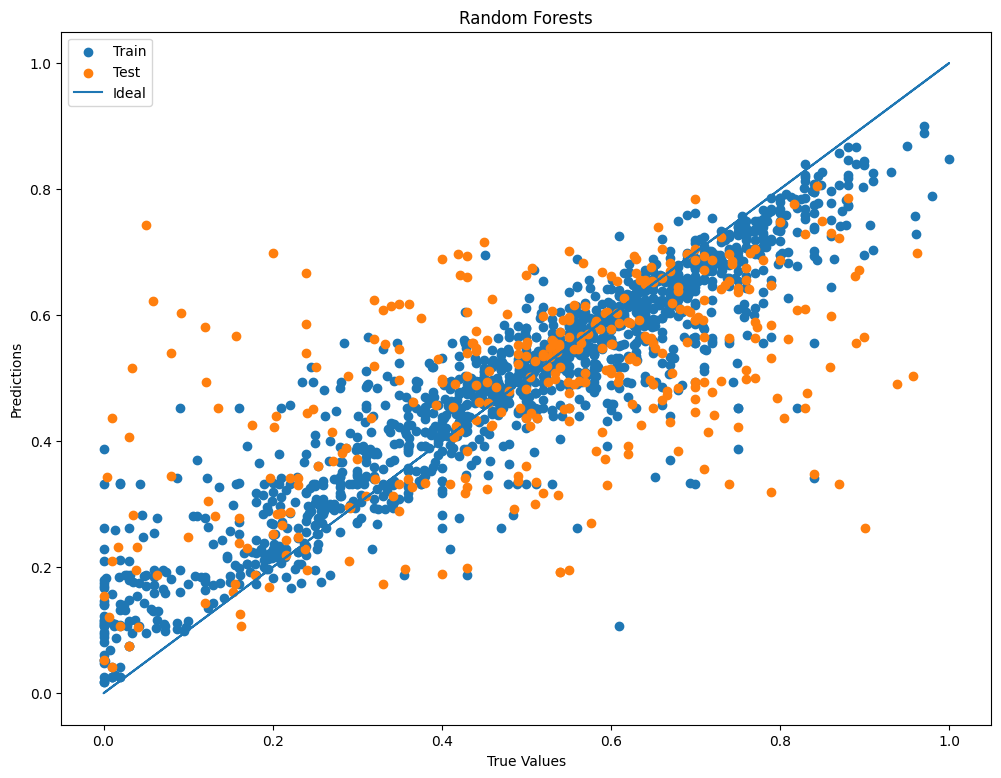

In [43]:
plt.figure(figsize=(12,9))
plt.scatter(Y_train, Y_pred_train, label='Train')
plt.scatter(Y_test, Y_pred_test, label='Test')
plt.plot(Y, Y, label='Ideal');
plt.legend()
plt.title('Random Forests')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

### Neural Networks

In [44]:
from tensorflow import keras

In [45]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [46]:
model = keras.Sequential(
    [
        # Inpute layer
        layers.Dense(32, activation='relu',input_shape=[X_train.shape[1]]),
        # Hidden layers
        layers.Dropout(0.1),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.1),
        # Output layer
        layers.Dense(1)
    ])

2022-11-16 09:56:53.269100: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-16 09:56:53.269139: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-16 09:56:53.269159: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-fc3d2631-9178-4bf3-9db3-87923c482dce): /proc/driver/nvidia/version does not exist
2022-11-16 09:56:53.292765: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [47]:
model.compile(loss='mse', optimizer='rmsprop');

In [48]:
model.fit(X_train, Y_train, epochs=200, validation_split = 0.1, verbose=0);

In [49]:
epoc_list = model.history.epoch
train_loss = np.sqrt(np.array(model.history.history['loss']))
test_loss = np.sqrt(np.array(model.history.history['val_loss']))

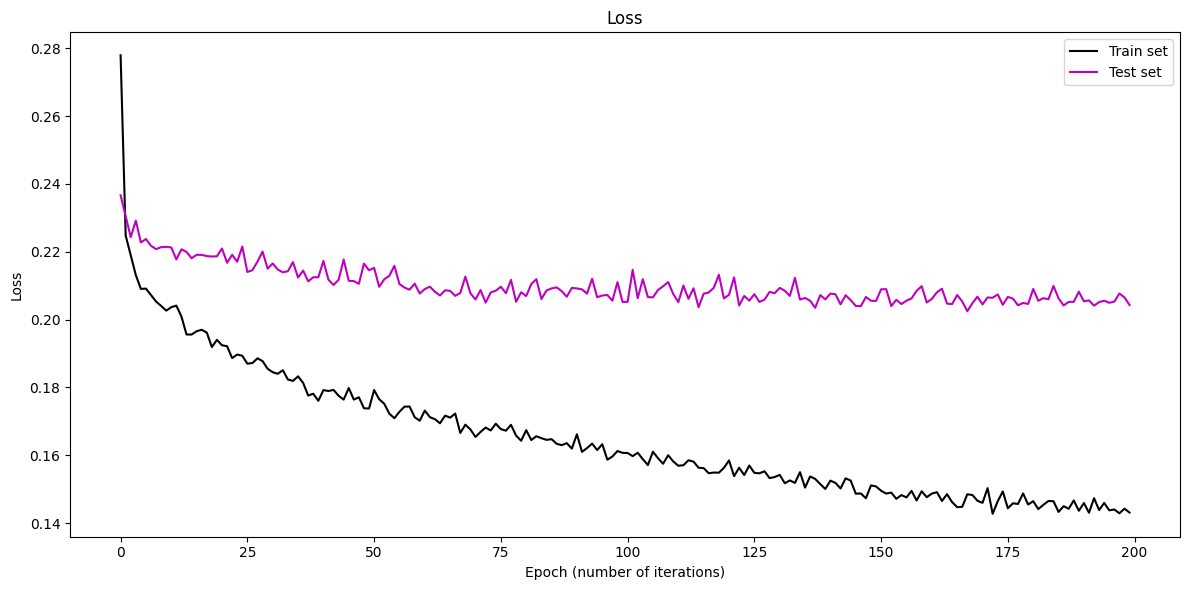

In [50]:
plt.figure(figsize=(12,6))
plt.title('Loss')
plt.xlabel('Epoch (number of iterations)')
plt.ylabel('Loss')
plt.plot(epoc_list, train_loss, 'k', label='Train set')
plt.plot(epoc_list, test_loss, 'm', label='Test set')
plt.legend()
# plt.yscale('log')
# plt.yticks(np.arange(2, 16, 2))
plt.tight_layout()

          

In [51]:
predict_on_train = model.predict(X_train).flatten()
predict_on_test = model.predict(X_test).flatten()

print('Score on training set:', sklearn.metrics.r2_score(Y_train, predict_on_train))
print('Score on test set:', sklearn.metrics.r2_score(Y_test, predict_on_test))

12/12 [==============================] - 0s 994us/step
Score on training set: 0.6212924274230354
Score on test set: 0.28384947718462794


In [52]:
Y_pred_train = model.predict(X_train)
Y_pred_test = model.predict(X_test)

12/12 [==============================] - 0s 1ms/step


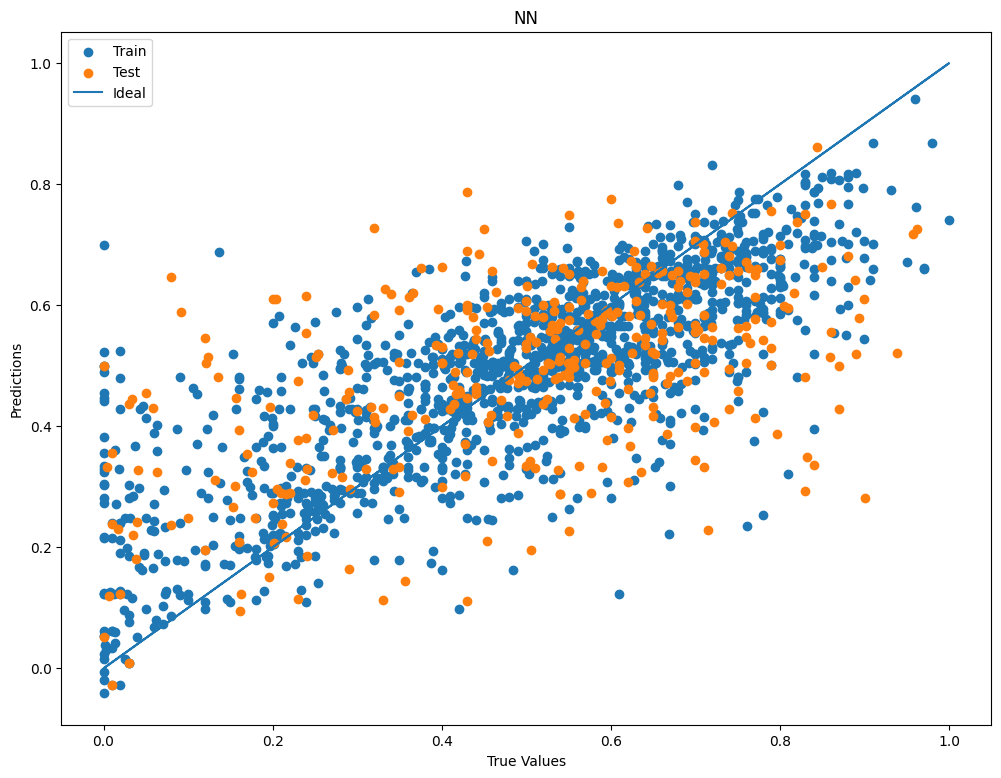

In [53]:
plt.figure(figsize=(12,9))
plt.scatter(Y_train, Y_pred_train, label='Train')
plt.scatter(Y_test, Y_pred_test, label='Test')
plt.plot(Y, Y, label='Ideal');
plt.legend()
plt.title('NN')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

We see that in this example the results are not as good as for the boston housing dataset. ML is not magic, and in real world examples the performance is not necessary good. In this case, we can conclude that the data we are using to predict the target is poor. In order to improve the model alternative more informative features should be considered.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fc3d2631-9178-4bf3-9db3-87923c482dce' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>